# **Install Transformers Library**

In [1]:
!pip install transformers
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Importing the libraries needed**

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import transformers
import json
import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    BertForSequenceClassification, 
    AlbertForSequenceClassification, 
    XLNetForSequenceClassification, 
    RobertaForSequenceClassification, 
    AutoTokenizer
)

from transformers import RobertaModel, AdamW
from transformers import get_linear_schedule_with_warmup
import time
from tqdm import tqdm
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    confusion_matrix
)  
from sys import platform
import os
import logging
logging.basicConfig(level=logging.ERROR)

# Hyperparameter tuning **

In [3]:
# max_seq_len = 512
# lr=1.25e-6
# Batch size
TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 16
PREDICT_BATCH_SIZE = 16
# Learning Rate
LEARNING_RATE = 1.25e-6 # 1e-6, 2e-5, 1e-4, 1e-3
# Epochs
NUM_TRAIN_EPOCHS = 3
MAX_SEQ_LENGTH = 128
# MAX_SEQ_LENGTH = 128

# Encoding sentences **

In [4]:
class NewsDataset(Dataset):
    """
    Encoding sentences
    """
    def __init__(self, bert_tokenizer, df, max_seq_len = MAX_SEQ_LENGTH):
        super(NewsDataset, self).__init__()
        self.bert_tokenizer = bert_tokenizer
        self.max_seq_len = max_seq_len
        self.input_ids, self.attention_mask, self.token_type_ids, self.labels = self.get_input(df)
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.token_type_ids[idx], self.labels[idx]
        
    # Convert dataframe to tensor
    def get_input(self, df):
        text = df['text'].values
        labels = df['label'].values
        
        # tokenizer
        tokens_seq = list(map(self.bert_tokenizer.tokenize, text)) # list of shape [sentence_len, token_len]
        
        # Get fixed-length sequence and its mask
        result = list(map(self.trunate_and_pad, tokens_seq))
        
        input_ids = [i[0] for i in result]
        attention_mask = [i[1] for i in result]
        token_type_ids = [i[2] for i in result]
        
        return (
               torch.Tensor(input_ids).type(torch.long), 
               torch.Tensor(attention_mask).type(torch.long),
               torch.Tensor(token_type_ids).type(torch.long), 
               torch.Tensor(labels).type(torch.long)
               )
    
    def trunate_and_pad(self, tokens_seq):
        # Concat '[CLS]' at the beginning
        tokens_seq = ['[CLS]'] + tokens_seq     
        # Truncate sequences of which the lengths exceed the max_seq_len
        if len(tokens_seq) > self.max_seq_len:
            tokens_seq = tokens_seq[0 : self.max_seq_len]           
        # Generate padding
        padding = [0] * (self.max_seq_len - len(tokens_seq))       
        # Convert tokens_seq to token_ids
        input_ids = self.bert_tokenizer.convert_tokens_to_ids(tokens_seq)
        input_ids += padding   
        # Create attention_mask
        attention_mask = [1] * len(tokens_seq) + padding     
        # Create token_type_ids
        token_type_ids = [0] * (self.max_seq_len)
        
        assert len(input_ids) == self.max_seq_len
        assert len(attention_mask) == self.max_seq_len
        assert len(token_type_ids) == self.max_seq_len
        
        return input_ids, attention_mask, token_type_ids

In [5]:
# bert_model = 'roberta-base'
bert_model = 'roberta-base'

# Download and save modle 

In [6]:
"""
model = XLNetForSequenceClassification.from_pretrained('xlnet-large-cased', num_labels = 2)
tokenizer = AutoTokenizer.from_pretrained('xlnet-large-cased', do_lower_case=True)
torch.save(model, 'Model/output/Xlnet/Xlnet_base/model-xlnet-large-cased.pth.tar')
torch.save(tokenizer, 'Model/output/Xlnet/Xlnet_base/tokenizer-xlnet-large-cased.pth.tar')
"""

"\nmodel = XLNetForSequenceClassification.from_pretrained('xlnet-large-cased', num_labels = 2)\ntokenizer = AutoTokenizer.from_pretrained('xlnet-large-cased', do_lower_case=True)\ntorch.save(model, 'Model/output/Xlnet/Xlnet_base/model-xlnet-large-cased.pth.tar')\ntorch.save(tokenizer, 'Model/output/Xlnet/Xlnet_base/tokenizer-xlnet-large-cased.pth.tar')\n"

# BERT Model **

In [22]:
class BertModel(nn.Module):
    def __init__(self, requires_grad = True):
        super(BertModel, self).__init__()
        # self.bert = BertForSequenceClassification.from_pretrained('textattack/bert-base-uncased-SST-2',num_labels = 2)
        # self.tokenizer = AutoTokenizer.from_pretrained('textattack/bert-base-uncased-SST-2', do_lower_case=True)
        self.bert = torch.load('Model/output/BERT/BERT_base/model-berta-base.pth.tar')
        self.tokenizer = torch.load('Model/output/BERT/BERT_base/tokenizer-berta-base.pth.tar')
        self.requires_grad = requires_grad
        self.device = torch.device("cuda")
        for param in self.bert.parameters():
            param.requires_grad = requires_grad  # Each parameter requires gradient

    def forward(self, batch_seqs, batch_seq_masks, batch_seq_segments, labels):
        loss, logits = self.bert(input_ids = batch_seqs, attention_mask = batch_seq_masks, 
                              token_type_ids=batch_seq_segments, labels = labels)[:2]
        probabilities = nn.functional.softmax(logits, dim=-1)
        return loss, logits, probabilities

# Albert Model **

In [23]:
class AlbertModel(nn.Module):
    def __init__(self, requires_grad = True):
        super(AlbertModel, self).__init__()
        # self.albert = AlbertForSequenceClassification.from_pretrained('albert-xxlarge-v2', num_labels = 2)
        # self.tokenizer = AutoTokenizer.from_pretrained('albert-xxlarge-v2', do_lower_case=True)
        self.albert = torch.load('Model/output/Albert/Albert_base/model-albert-xxlarge-v2.pth.tar')
        self.tokenizer = torch.load('Model/output/Albert/Albert_base/tokenizer-albert-xxlarge-v2.pth.tar')
        self.requires_grad = requires_grad
        self.device = torch.device("cuda")
        for param in self.albert.parameters():
            param.requires_grad = True  # Each parameter requires gradient

    def forward(self, batch_seqs, batch_seq_masks, batch_seq_segments, labels):
        loss, logits = self.albert(input_ids = batch_seqs, attention_mask = batch_seq_masks, 
                              token_type_ids=batch_seq_segments, labels = labels)[:2]
        probabilities = nn.functional.softmax(logits, dim=-1)
        return loss, logits, probabilities

# RoBERTa Model **

In [7]:
class RobertModel(nn.Module):
    def __init__(self, requires_grad = True):
        super(RobertModel, self).__init__()
        # config = RobertaForSequenceClassification.from_pretrained( 'roberta-base', output_hidden_states=True, num_labels = 2)    
        # self.bert = RobertaForSequenceClassification.from_pretrained(bert_model, output_hidden_states=True, num_labels = 2)
        # self.tokenizer = AutoTokenizer.from_pretrained(bert_model, do_lower_case=True)
        self.bert = torch.load('Model/output/Roberta/Roberta-base/model-roberta-base.pth')
        self.tokenizer = torch.load('Model/output/Roberta/Roberta-base/tokenizer-roberta-base.pth')
        self.requires_grad = requires_grad
        self.device = torch.device("cuda")
        for param in self.bert.parameters():
            param.requires_grad = requires_grad  # Each parameter requires gradient

    def forward(self, batch_seqs, batch_seq_masks, batch_seq_segments, labels = None):

        loss, logits = self.bert(input_ids = batch_seqs, attention_mask = batch_seq_masks, 
                                  token_type_ids=batch_seq_segments, labels = labels)[:2]
        # print(logits)
        probabilities = nn.functional.softmax(logits, dim=-1)
        # print(probabilities)
        return loss, logits, probabilities

# Xlnet Model **

In [25]:
class XlnetModel(nn.Module):
    def __init__(self, requires_grad = True):
        super(XlnetModel, self).__init__()
        # self.xlnet = XLNetForSequenceClassification.from_pretrained('xlnet-large-cased', num_labels = 2)
        # self.tokenizer = AutoTokenizer.from_pretrained('xlnet-large-cased', do_lower_case=True)
        self.xlnet = torch.load('Model/output/Xlnet/Xlnet_base/model-xlnet-large-cased.pth.tar')
        self.tokenizer = torch.load('Model/output/Xlnet/Xlnet_base/tokenizer-xlnet-large-cased.pth.tar')
        self.requires_grad = requires_grad
        self.device = torch.device("cuda")
        for param in self.xlnet.parameters():
            param.requires_grad = requires_grad  # Each parameter requires gradient

    def forward(self, batch_seqs, batch_seq_masks, batch_seq_segments, labels):
        loss, logits = self.xlnet(input_ids = batch_seqs, attention_mask = batch_seq_masks, 
                              token_type_ids=batch_seq_segments, labels = labels)[:2]
        probabilities = nn.functional.softmax(logits, dim=-1)
        return loss, logits, probabilities

In [6]:
bertmodel = BertModel(requires_grad = True)

In [8]:
bertmodel = AlbertModel(requires_grad = True)

In [8]:
bertmodel = RobertModel(requires_grad = True)

In [6]:
bertmodel = XlnetModel(requires_grad = True)

# Correct Predictions Function**

In [13]:
def correct_predictions(output_probabilities, targets):
    _, out_classes = output_probabilities.max(dim=1)
    correct = (out_classes == targets).sum()
    return correct.item()

# Training Function**

In [14]:
def train(model, dataloader, optimizer, epoch_number, max_gradient_norm, scheduler):
    # Switch the model to train mode.
    model.train()
    device = model.device
    epoch_start = time.time()
    batch_time_avg = 0.0
    running_loss = 0.0
    correct_preds = 0
    accuracy = 0.0
    loss_app = 0.0
    tqdm_batch_iterator = tqdm(dataloader)
    for batch_index, (batch_seqs, batch_seq_masks, batch_seq_segments, batch_labels) in enumerate(tqdm_batch_iterator):
        batch_start = time.time()
        # Move input and output data to the GPU if it is used.
        seqs, masks, segments, labels = batch_seqs.to(device), batch_seq_masks.to(device), batch_seq_segments.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        loss, logits, probabilities = model(seqs, masks, segments, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_gradient_norm)
        optimizer.step()
        scheduler.step()
        batch_time_avg += time.time() - batch_start
        running_loss += loss.item()
        correct_preds += correct_predictions(probabilities, labels)
        description = "Avg. batch proc. time: {:.4f}s, loss: {:.4f}"\
                      .format(batch_time_avg/(batch_index+1), running_loss/(batch_index+1))
        tqdm_batch_iterator.set_description(description)
    epoch_time = time.time() - epoch_start
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct_preds / len(dataloader.dataset)
    return epoch_time, epoch_loss, epoch_accuracy


# Validation Function**

In [15]:
def validate(model, dataloader):
    # Switch to evaluate mode.
    model.eval()
    device = model.device
    epoch_start = time.time()
    running_loss = 0.0
    running_accuracy = 0.0
    all_prob = []
    all_labels = []
    # Deactivate autograd for evaluation.
    with torch.no_grad():
        for (batch_seqs, batch_seq_masks, batch_seq_segments, batch_labels) in dataloader:
            # Move input and output data to the GPU if one is used.
            seqs = batch_seqs.to(device)
            masks = batch_seq_masks.to(device)
            segments = batch_seq_segments.to(device)
            labels = batch_labels.to(device)
            loss, logits, probabilities = model(seqs, masks, segments, labels)
            running_loss += loss.item()
            running_accuracy += correct_predictions(probabilities, labels)
            all_prob.extend(probabilities[:,1].cpu().numpy())
            all_labels.extend(batch_labels)
    epoch_time = time.time() - epoch_start
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = running_accuracy / (len(dataloader.dataset))
    return epoch_time, epoch_loss, epoch_accuracy, roc_auc_score(all_labels, all_prob), all_prob


# Test Function**

In [16]:
def test(model, dataloader):
    # Switch the model to eval mode.
    model.eval()
    device = model.device
    time_start = time.time()
    batch_time = 0.0
    accuracy = 0.0
    all_prob = []
    all_labels = []
    # Deactivate autograd for evaluation.
    with torch.no_grad():
        for (batch_seqs, batch_seq_masks, batch_seq_segments, batch_labels) in dataloader:
            batch_start = time.time()
            # Move input and output data to the GPU if one is used.
            seqs, masks, segments, labels = batch_seqs.to(device), batch_seq_masks.to(device), batch_seq_segments.to(device), batch_labels.to(device)
            _, _, probabilities = model(seqs, masks, segments, labels)
            accuracy += correct_predictions(probabilities, labels)
            batch_time += time.time() - batch_start
            all_prob.extend(probabilities[:,1].cpu().numpy())
            all_labels.extend(batch_labels)
    batch_time /= len(dataloader)
    total_time = time.time() - time_start
    accuracy /= (len(dataloader.dataset))

    return batch_time, total_time, accuracy, all_prob, all_labels

In [17]:
# Training ,Validation and testing model**

In [18]:
def model_train_validate_test(train_df, dev_df, test_df, target_dir, 
         max_seq_len=MAX_SEQ_LENGTH,
         epochs=NUM_TRAIN_EPOCHS,
         batch_size=TRAIN_BATCH_SIZE,
         lr=LEARNING_RATE,
         patience=1,
         max_grad_norm=10.0,
         if_save_model=True,
         checkpoint=None):

    tokenizer = bertmodel.tokenizer
    
    print(20 * "=", " Preparing for training ", 20 * "=")
    # Path to save the model, create a folder if not exist.
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        
    # -------------------- Data loading --------------------------------------#
    print("\t* Loading training data...")
    train_data = NewsDataset(tokenizer,train_df, max_seq_len=max_seq_len)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    print("\t* Loading validation data...")
    dev_data = NewsDataset(tokenizer, dev_df, max_seq_len=max_seq_len)
    dev_loader = DataLoader(dev_data, shuffle=True, batch_size=batch_size)
    
    print("\t* Loading test data...")
    test_data = NewsDataset(tokenizer, test_df, max_seq_len=max_seq_len) 
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

    

    
   
    # -------------------- Model definition ------------------- --------------#
    
    print("\t* Building model...")
    device = torch.device("cuda")
    model = bertmodel.to(device)
    
    # -------------------- Preparation for training  -------------------------#
    
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
            {
                    'params':[p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                    'weight_decay':0.01
            },
            {
                    'params':[p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                    'weight_decay':0.0
            }
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
    total_steps = len(train_data) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    
    best_score = 0.0
    start_epoch = 1
    # Data for loss curves plot
    epochs_count = []
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    valid_aucs = []
    epoch_times = []
    # Continuing training from a checkpoint if one was given as argument
    if checkpoint:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint["epoch"] + 1
        best_score = checkpoint["best_score"]
        print("\t* Training will continue on existing model from epoch {}...".format(start_epoch))
        model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        epochs_count = checkpoint["epochs_count"]
        train_losses = checkpoint["train_losses"]
        train_accuracy = checkpoint["train_accuracy"]
        valid_losses = checkpoint["valid_losses"]
        valid_accuracy = checkpoint["valid_accuracy"]
        valid_auc = checkpoint["valid_auc"]
        epoch_times = checkpoint["epoch_times"]
     # Compute loss and accuracy before starting (or resuming) training.
    _, valid_loss, valid_accuracy, auc, _ = validate(model, dev_loader)
    train_losses.append(valid_loss)
    train_accuracies.append(valid_accuracy) 
    #######################################
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    valid_aucs.append(auc)
    print("\n* Validation loss before training: {:.4f}, accuracy: {:.4f}%, auc: {:.4f}".format(valid_loss, (valid_accuracy*100), auc))
    
    # -------------------- Training epochs -----------------------------------#
    
    print("\n", 20 * "=", "Training bert model on device: {}".format(device), 20 * "=")
    patience_counter = 0
    for epoch in range(start_epoch, epochs + 1):
        epochs_count.append(epoch)

        print("* Training epoch {}:".format(epoch))
        epoch_time, epoch_loss, epoch_accuracy = train(model, train_loader, optimizer, epoch, max_grad_norm, scheduler)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)  
        epoch_times.append(epoch_time)
        print("-> Training time: {:.4f}s, loss = {:.4f}, accuracy: {:.4f}%".format(epoch_time, epoch_loss, (epoch_accuracy*100)))
        
        print("* Validation for epoch {}:".format(epoch))
        epoch_time, epoch_loss, epoch_accuracy , epoch_auc, _ = validate(model, dev_loader)
        valid_losses.append(epoch_loss)
        valid_accuracies.append(epoch_accuracy)
        valid_aucs.append(epoch_auc)
        print("-> Valid. time: {:.4f}s, loss: {:.4f}, accuracy: {:.4f}%, auc: {:.4f}\n"
              .format(epoch_time, epoch_loss, (epoch_accuracy*100), epoch_auc))
    
        # Early stopping on validation accuracy.
        if epoch_accuracy < best_score:
            patience_counter += 1
        else:
            best_score = epoch_accuracy
            patience_counter = 0
            if (if_save_model):
                # torch.save(model.state_dict(), os.path.join(target_dir, "model_none.pth"))
                torch.save({"epoch": epoch, 
                       "model": model.state_dict(),
                       "optimizer": optimizer.state_dict(),
                       "tokenizer":tokenizer,
                       "best_score": best_score,
                       "epochs_count": epochs_count,
                       "train_losses": train_losses,
                       "train_accuracy": train_accuracies,
                       "valid_losses": valid_losses,
                       "valid_accuracy": valid_accuracies,
                       "valid_auc": valid_aucs,
                       "epoch_times": epoch_times,
                       },
                       os.path.join(target_dir, "model_albert.pth.tar"))
    
                print("save model succesfully!\n")
            
            # run model on test set and save the prediction result to csv
            print("* Test for epoch {}:".format(epoch))
            _, _, test_accuracy, _, all_prob = validate(model, test_loader)
            print("Test accuracy: {:.4f}%\n".format(test_accuracy))
            test_prediction = pd.DataFrame({'prob_1':all_prob})
            test_prediction['prob_0'] = 1-test_prediction['prob_1']
            test_prediction['prediction'] = test_prediction.apply(lambda x: 0 if (x['prob_0'] > x['prob_1']) else 1, axis=1)
            test_prediction = test_prediction[['prob_0', 'prob_1', 'prediction']]
            test_prediction.to_csv(os.path.join(target_dir,"test_prediction_model3.csv"), index=False)
            
        if patience_counter >= patience:
            print("-> Early stopping: patience limit reached, stopping...")
            break

# main**

In [15]:
if __name__ == "__main__":
    data_path = "../Datasets/HuggingFaceDataset/cc_news/"
    train_df = pd.read_csv(os.path.join(data_path,"train.csv"))
    print(f"Trining Data info: {train_df.shape}")
    val_df = pd.read_csv(os.path.join(data_path,"val.csv"))
    print(f"Validation Data info: {val_df.shape}")
    test_df = pd.read_csv(os.path.join(data_path,"test.csv")).head(1)
    print(f"Testing Data info: {test_df.shape}")
    target_dir = "Model/"
    model_train_validate_test(train_df, val_df, test_df, target_dir)

Trining Data info: (24353, 4)
Validation Data info: (8117, 4)
Testing Data info: (1, 5)
====================  Preparing for training  ====================
	* Loading training data...
	* Loading validation data...


Token indices sequence length is longer than the specified maximum sequence length for this model (774 > 512). Running this sequence through the model will result in indexing errors


	* Loading test data...
	* Building model...


/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



* Validation loss before training: 1.2464, accuracy: 45.4232%, auc: 0.5096

 ==================== Training bert model on device: cuda ====================
* Training epoch 1:


Avg. batch proc. time: 2.3311s, loss: 0.9491:   2%|▏         | 26/1523 [02:26<2:20:36,  5.64s/it]


KeyboardInterrupt: 

# Test Model**

In [19]:
def model_load_test(test_df, target_dir,
                    test_prediction_dir,
                    test_prediction_name,
                    max_seq_len=MAX_SEQ_LENGTH, batch_size=PREDICT_BATCH_SIZE):
    
    bertmodel = RobertModel(requires_grad = True)
    tokenizer = bertmodel.tokenizer
    device = torch.device("cuda")
    
    print(20 * "=", " Preparing for testing ", 20 * "=")
    if platform == "linux" or platform == "linux2":
        checkpoint = torch.load(os.path.join(target_dir, "roberta-model2.pth.tar"))
    else:
        checkpoint = torch.load(os.path.join(target_dir, "roberta-model2.pth.tar"), map_location=device)
        
    print("\t* Loading test data...")    
    test_data = NewsDataset(tokenizer,test_df, max_seq_len = max_seq_len) 
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

    # Retrieving model parameters from checkpoint.
    print("\t* Building model...")
    model = bertmodel.to(device)
    model.load_state_dict(checkpoint["model"])
    print(20 * "=", " Testing BERT model on device: {} ".format(device), 20 * "=")
    
    batch_time, total_time, accuracy, all_prob, all_labels = test(model, test_loader)
    print("\n-> Average batch processing time: {:.4f}s, total test time: {:.4f}s, accuracy: {:.4f}%\n".format(batch_time, total_time, (accuracy*100)))
    
    test_prediction = pd.DataFrame({'prob_1':all_prob})
    test_prediction['prob_0'] = 1-test_prediction['prob_1']
    test_prediction['prediction'] = test_prediction.apply(lambda x: 0 if (x['prob_0'] > x['prob_1']) else 1, axis=1)
    test_prediction['label'] = [i.item() for i in all_labels]
    test_prediction = test_prediction[['prob_0', 'prob_1', 'prediction','label']]
    
    if not os.path.exists(test_prediction_dir):
        os.makedirs(test_prediction_dir)
    test_prediction.to_csv(os.path.join(test_prediction_dir, test_prediction_name), index=False)

    y_actu = all_labels
    y_pred = test_prediction['prediction'].to_list()
    cf_matrix = confusion_matrix(y_actu, y_pred)
    class_rep = classification_report(y_actu, y_pred,labels=[0,1],output_dict=True)
    return cf_matrix, class_rep

# Testing main**

In [20]:
if __name__ == "__main__":
    import pandas as pd
    test_df = pd.read_csv('../Datasets/HuggingFaceDataset/GonzaloA-fake_news/Dataset(02)/test.csv')
    target_dir = 'Model/output/Roberta/'
    test_prediction_dir = 'Model/output/Roberta/test_pred'
    test_prediction_name = 'test_prediction_model02.csv' 
    MAX_SEQ_LENGTH = 512
    cf_matrix, class_rep = model_load_test(test_df, target_dir,test_prediction_dir,test_prediction_name,max_seq_len=MAX_SEQ_LENGTH, batch_size=PREDICT_BATCH_SIZE)

====================  Preparing for testing  ====================


Token indices sequence length is longer than the specified maximum sequence length for this model (892 > 512). Running this sequence through the model will result in indexing errors


	* Loading test data...
	* Building model...
====================  Testing BERT model on device: cuda  ====================

-> Average batch processing time: 0.3947s, total test time: 200.9943s, accuracy: 98.1767%



<AxesSubplot:>

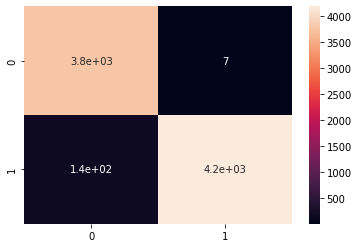

In [21]:
sns.heatmap(cf_matrix, annot=True)

# Classification report**

<AxesSubplot:>

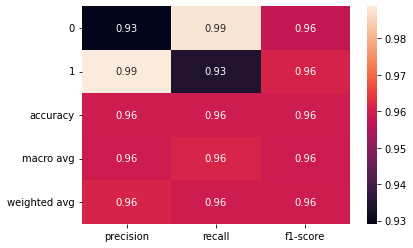

In [18]:
# .iloc[:-1, :] to exclude support
crp_plot = sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :].T, annot=True)
crp_plot
crp_plot.figure.savefig("model1_class_rep.png")

# Confusion matrix**

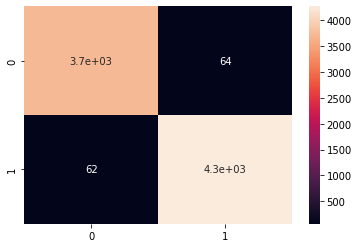

In [157]:
cfm_plot = sns.heatmap(cf_matrix, annot=True)
cfm_plot.figure.savefig("model1_cfm.png")